In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from scipy.stats import ttest_ind, pearsonr
from scipy.stats import pearsonr
from tqdm import tqdm
from operator import itemgetter
from matplotlib import colors

from helpers import *

import warnings

# Ignoring warnings to improve code readability

warnings.filterwarnings("ignore")

# Resetting Matplotlib default settings
plt.rcdefaults()

# Set the maximum number of rows to display
pd.set_option('display.max_rows', 20)

%load_ext autoreload
%autoreload 2

c:\Users\User\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


je propose de pas re entrer dans les details de comment on a une la dataframe d'acteurs avec une full career comme c'etait pour le P2 (et que c'est un peu douteux (ou si on veut change ca, faut que j'en parle avc d'autres gens car je vois pas comment faire mieux sans perdre trop d'acteurs)), mais de le prendre un peu pour acquis. Tout ce qui est apres ce markdown est la partie "propre"

Imports to add:

In [4]:
from collections import Counter
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

## Career characterization

The goal of this section is to study the different characteristics of the career trajectories of the actors, aiming to answer the question: What characterizes the career evolution of actors? The acting careers will be represented as profile sequences (which are yearly time series of acting jobs) and their various characteristics and properties will be analyzed. This will also include the exploration of potential gender inequalities in the multiple factors that will be considered.  


In the following, we will use the previously constructed actors-oriented dataframe containing only full careers.

To ensure an accurate assessment of careers and to avoid erroneously identifying a mid-career movie as the initial one due to a lack of data before it, or as the last one while the actor could still be actively engaged in his career, we had decided to consider actors born after the release year of the earliest movie included in our dataset and dropped some of the newest actors with a certain safety margin. More details concerning these choices can be obtained in the Milestone 2 notebook.

In [ ]:
DATA_FOLDER = "../Data/"

actors_load = pd.read_csv(
    DATA_FOLDER + "actors.csv",
    converters={
        "fbID": parse_list_actors,
        "ageAtMovieRelease": parse_dict,
        "category": parse_dict,
        "winner": parse_dict,
    },
)
movies_load = pd.read_csv(
    DATA_FOLDER + "movies.csv",
    converters={
        "languages": parse_list,
        "countries": parse_list,
        "genresCmu": parse_list,
    },
)

In [ ]:
actors_load['actorDOB'] = pd.to_datetime(actors_load['actorDOB'], errors="coerce") 
actors_load['yearOfBirth'] = actors_load['actorDOB'].dt.year  

# Define a function to extract the minimum age from the ageAtMovieRelease dictionary
def get_min_age(x):
    if isinstance(x, dict):
        return min(x.values())
    else:
        return np.nan

# Define a function to extract the maximum age from the ageAtMovieRelease dictionary
def get_max_age(x):
    if isinstance(x, dict):
        return max(x.values())
    else:
        return np.nan


actors_full_career = actors_load[actors_load['yearOfBirth'] > 1888]
# Apply the function to the ageAtMovieRelease column
actors_full_career['ageAtFirstMovie'] = actors_full_career['ageAtMovieRelease'].apply(get_min_age)

actors_full_career = actors_full_career[actors_full_career['yearOfBirth'] < movies_load['releaseYear'].max() - 61]
# Apply the function to the ageAtMovieRelease column
actors_full_career['ageAtLastMovie'] = actors_full_career['ageAtMovieRelease'].apply(get_max_age)
# Calculate career length
actors_full_career['careerLength'] = actors_full_career['ageAtLastMovie'] - actors_full_career['ageAtFirstMovie']

In [5]:
print("Number of actors with a full career in constructed dataframe:", actors_full_career.size)

print("Minimum date of birth of actor in constructed dataframe:", actors_full_career['actorDOB'].min())
print("Maximum date of birth of actor in constructed dataframe:", actors_full_career['actorDOB'].max())

print("Minimum release year of movie:", movies_load['releaseYear'].min())
print("Maximum release year of first movie:", movies_load['releaseYear'].max())

actors_full_career.head()

Number of actors with a full career in constructed dataframe: 380160
Minimum date of birth of actor in constructed dataframe: 1889-01-01 00:00:00
Maximum date of birth of actor in constructed dataframe: 1954-12-31 00:00:00
Minimum release year of movie: 1888.0
Maximum release year of first movie: 2016.0


,fbActorID,actorName,actorGender,actorDOB,actorHeight,actorEthnicity,fbID,ageAtMovieRelease,category,winner,numMovies,yearOfBirth,ageAtFirstMovie,ageAtLastMovie,careerLength
1,/m/010q36,Fred Rogers,M,1928-03-20,NaN,NaN,[/m/033pf1],{'/m/033pf1': 67.0},NaN,NaN,1,1928.0,67.0,67.0,0.0
3,/m/010xjr,Richard Harris,M,1930-10-01,1.85,Irish people,"[/m/015gl2, /m/0273r02, /m/02qf1bq, /m/02qf7sl...","{'/m/0273r02': 68.0, '/m/02qf1bq': 36.0, '/m/0...",{'/m/015gl2': 'ACTOR'},{'/m/015gl2': False},52,1930.0,28.0,72.0,44.0
4,/m/0112yl,Toshiro Mifune,M,1920-04-01,1.74,NaN,"[/m/018lr7, /m/019npw, /m/01j5x_, /m/01nv95, /...","{'/m/018lr7': 41.0, '/m/019npw': 30.0, '/m/01n...",NaN,NaN,48,1920.0,28.0,69.0,41.0
6,/m/011_24,Les Brown,M,1912-03-14,NaN,NaN,"[/m/02stxk, /m/09n9rnb]","{'/m/02stxk': 50.0, '/m/09n9rnb': 30.0}",NaN,NaN,2,1912.0,30.0,50.0,20.0
8,/m/011_3s,Lily Tomlin,F,1939-09-01,1.73,NaN,"[/m/027qjyd, /m/028kj0, /m/02phv19, /m/02q3fdr...","{'/m/027qjyd': 52.0, '/m/028kj0': 52.0, '/m/02...",NaN,NaN,27,1939.0,37.0,68.0,31.0


First, let's construct the career profile sequence of each actor. The profile sequence is a vector of the length of the maximum career length in our dataset, denoting the number of movies done by an actor for each year of his career. This information will help us analyze and understand the typical career trajectories of actors in our dataset.

Max career length: 90


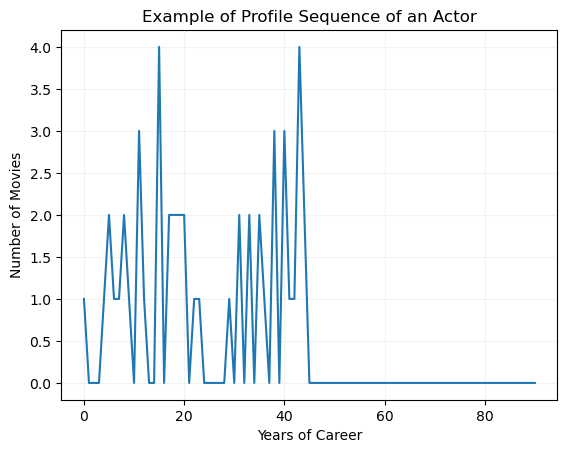

In [6]:
# Get the maximum career length
max_career_length = int(actors_full_career['careerLength'].max())
print(f"Max career length: {max_career_length}")

# Drop rows with missing values in the 'ageAtMovieRelease' column
actors_full_career.dropna(subset=['ageAtMovieRelease'], inplace=True)

# Define a function to calculate the profile sequence for each actor
def get_profile_sequence(x, max_career_length):
    age_at_first_movie = float(x.ageAtFirstMovie)  

    age_list = []
    for value in x.ageAtMovieRelease.values():
        age_list.append(float(value) - age_at_first_movie)
    age_list.sort()

    # Count the number of movies for each age
    movie_count = Counter(age_list)

    # Create a list of size max career length and fill it with zeros
    profile_sequence = [0] * (max_career_length + 1)

    # Fill the list with the number of movies for each age
    for key, value in movie_count.items():
        profile_sequence[int(key)] = value

    return profile_sequence

# Apply the function to calculate the profile sequence for each actor and create a new column 'profileSequence'
actors_full_career['profileSequence'] = actors_full_career.apply(lambda x: get_profile_sequence(x, max_career_length), axis=1)

# Example of career profile sequence of an actor
actor_index = 3 
actor_profile_sequence = actors_full_career.loc[actor_index, 'profileSequence']

# Plot the profile sequence
plt.plot(range(len(actor_profile_sequence)), actor_profile_sequence, linestyle="-")
plt.title("Example of Profile Sequence of an Actor")
plt.xlabel("Years of Career")
plt.ylabel("Number of Movies")
plt.grid(alpha=0.15)
plt.show()

Let's proceed with clustering the profile sequences using K-means to identify different types of career trajectories. 

To determine the optimal number of clusters, we will employ the silhouette score. A higher silhouette score indicates a better-defined separation of clusters. We opted for Euclidean distance over Manhattan distance in our clustering analysis, as its ability to emphasize larger differences across all dimensions, aligns better with our goal of penalizing more significant deviations in career trajectories.

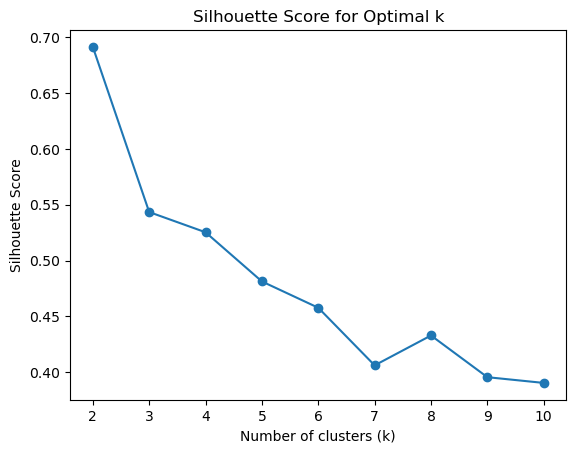

In [7]:
# Get the profile sequences
profile_sequences = actors_full_career['profileSequence'].tolist()

# Convert the profile sequences to a numpy array
X = np.array(profile_sequences)

# Silhouette Score
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# Plotting the Silhouette Score
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

The Silhouette score is highest for k = 2, which will thus be adopted in the subsequent step.

In [8]:
# Get the profile sequences
profile_sequences = actors_full_career['profileSequence'].tolist()

# Convert the profile sequences to a numpy array
X = np.array(profile_sequences)

# Define the number of clusters
n_clusters = 2

# Initialize the K-means clustering algorithm
kmeans = KMeans(n_clusters=n_clusters)

# Fit the data to the K-means algorithm
kmeans.fit(X)

# Get the cluster labels for each profile sequence
cluster_labels = kmeans.labels_

# Add the cluster labels to the actors_full_career dataframe
actors_full_career['clusterLabel'] = cluster_labels

clusterLabel
0    20971
1     1487
dtype: int64


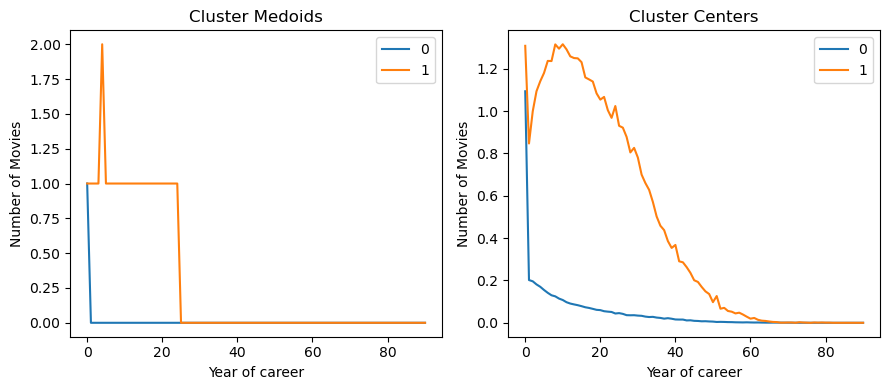

In [9]:
# Group the actors by cluster label
grouped_actors = actors_full_career.groupby('clusterLabel')

# Print the number of actors in each cluster
print(grouped_actors.size())

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

# Calculate the distance between each data point and the cluster centers
distances = cdist(X, cluster_centers)

# Find the index of the data point closest to each cluster center
cluster_medoids = np.argmin(distances, axis=0)

# Get the profile sequences of the cluster medoids
medoid_profile_sequences = X[cluster_medoids]

# Plot the cluster medoids and cluster centers as subplots
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

# Plot the cluster medoids
axs[0].plot(medoid_profile_sequences.T)
axs[0].set_xlabel('Year of career')
axs[0].set_ylabel('Number of Movies')
axs[0].set_title('Cluster Medoids')
axs[0].legend(range(n_clusters))

# Plot the cluster centers
axs[1].plot(cluster_centers.T)
axs[1].set_xlabel('Year of career')
axs[1].set_ylabel('Number of Movies')
axs[1].set_title('Cluster Centers')
axs[1].legend(range(n_clusters))

plt.tight_layout()
plt.show()

We can now understand why we obtained k = 2 as the optimal number of clusters. A significant percentage of actors, approximately 90%, have a brief presence in the movie industry, participating in a small number of movies before exiting the scene (as seen in the histogram below). This aligns with the reality of the film industry, as it is very difficult to build an acting career, and many give up. To better distinguish differences in career trajectories among actors with more extensive careers, we will exclude those who have only done less than 5 movies in their acting career.

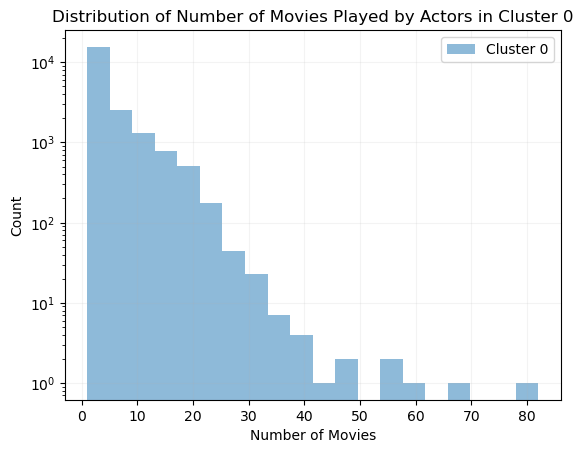

Number of actors that have played in less than 5 movies: 14430


In [24]:
# Plot the distribution of the number of movies played by actors in cluster 0
cluster_0 = grouped_actors.get_group(0)
plt.hist(cluster_0['numMovies'], bins=20, alpha=0.5, label='Cluster 0', log=True)

plt.title('Distribution of Number of Movies Played by Actors in Cluster 0')
plt.xlabel('Number of Movies')
plt.ylabel('Count')
plt.legend()
plt.grid(alpha=0.15)
plt.show()

num_actors_five_movie = (actors_full_career['numMovies'] < 5).sum()
print(f"Number of actors that have played in less than 5 movies: {num_actors_five_movie}")

However, before progressing to actors who have participated in at least 5 movies, let's analyze the gender distribution within the two clusters—namely, the "unsuccessful" and "successful" in building an acting career, which can be seen as equivalent to securing acting jobs consistently.

In [22]:
num_female_actors = actors_full_career["actorGender"].value_counts()["F"]
num_male_actors = actors_full_career["actorGender"].value_counts()["M"]
proportion_male_female = num_female_actors / (num_female_actors + num_male_actors)

print(f"Percentage of female actors: {proportion_male_female:.2%}")

# Group the actors by cluster label
grouped_actors = actors_full_career.groupby('clusterLabel')

# Count the number of females in each cluster
female_counts = grouped_actors['actorGender'].apply(lambda x: (x == 'F').sum())

# Calculate the total number of actors in each cluster
cluster_sizes = grouped_actors.size()

# Calculate the percentage of females in each cluster
female_percentages = (female_counts / cluster_sizes) * 100

# Print the percentage of females in each cluster
for cluster_label, female_percentage in female_percentages.items():
    print(f"Cluster {cluster_label}: {female_percentage:.2f}% of females")


Percentage of female actors: 33.27%
Cluster 0: 33.16% of females
Cluster 1: 25.22% of females


Firstly, it can be noted that the percentage of female actors is significantly lower than the percentage of male actors. However, this percentage further diminishes in the successful group, highlighting gender inequality. To assess whether the difference in percentages is statistically significant, let's conduct a t-test. The fraction of females can be treated as the mean of a boolean variable representing whether an actor is female or not.

In [32]:
# Extract the gender labels for successful and unsuccessful clusters
female_labels_successful = actors_full_career[actors_full_career['clusterLabel'] == 0]['actorGender']
female_labels_unsuccessful = actors_full_career[actors_full_career['clusterLabel'] == 1]['actorGender']

# Perform the t-test
t_stat, p_value = ttest_ind(female_labels_successful == 'F', female_labels_unsuccessful == 'F')

print(f"t-statistic: {t_stat}")
print(f"p-value: {p_value}")

# Check if the difference is statistically significant at a 0.05 significance level
if p_value < 0.05:
    print("The difference in percentages is statistically significant.")
else:
    print("The difference in percentages is not statistically significant.")


T-statistic: 6.313159465803446
P-value: 2.785118495538666e-10
The difference in percentages is statistically significant.


Since the p-value is below the significance threshold (commonly set at 0.05), we reject the null hypothesis. This indicates that there is a statistically significant difference between the percentages of female actors in the "successful" and "unsuccessful" in building an acting career clusters. 

In [12]:
# Keep only actors that have played in at least 5 movies
actors_full_extensive_career = actors_full_career[actors_full_career['numMovies'] >= 5]

Now, let's repeat the clustering procedure to see if we can identify distinct career trajectories.

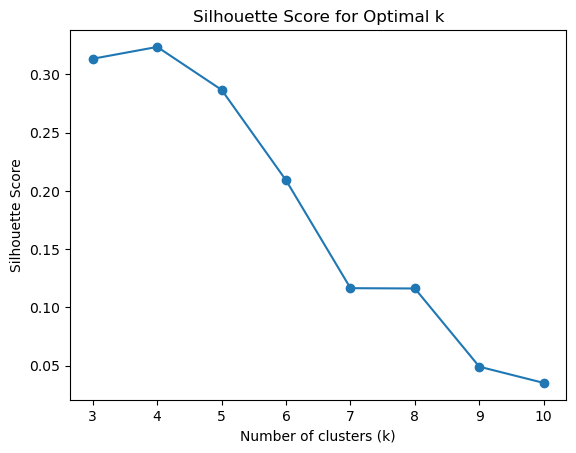

In [13]:
# Get the profile sequences
profile_sequences = actors_full_extensive_career['profileSequence'].tolist()

# Convert the profile sequences to a numpy array
X = np.array(profile_sequences)

# Silhouette Score
silhouette_scores = []
for i in range(3, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# Plotting the Silhouette Score
plt.plot(range(3, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

The Silhouette score is maximized for k = 4.

In [14]:
# Get the profile sequences
profile_sequences = actors_full_extensive_career['profileSequence'].tolist()

# Convert the profile sequences to a numpy array
X = np.array(profile_sequences)

# Define the number of clusters
n_clusters = 4

# Initialize the K-means clustering algorithm
kmeans = KMeans(n_clusters=n_clusters)

# Fit the data to the K-means algorithm
kmeans.fit(X)

# Get the cluster labels for each profile sequence
cluster_labels = kmeans.labels_

# Add the cluster labels to the actors_full_extensive_career dataframe
actors_full_extensive_career['clusterLabel'] = cluster_labels

clusterLabel
0      33
1    6423
2     602
3     970
dtype: int64


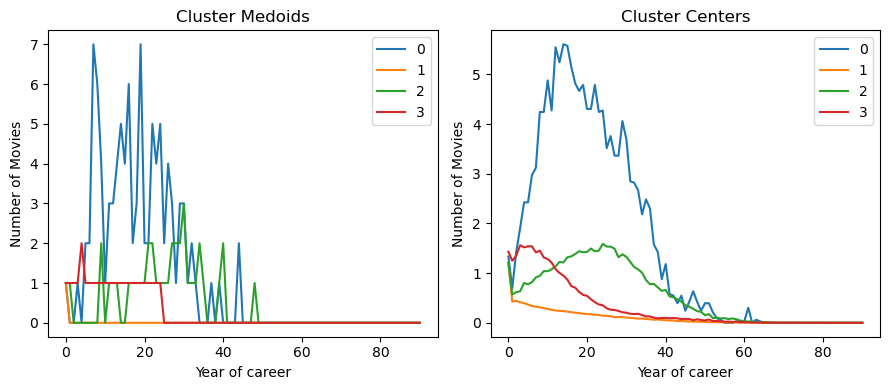

In [15]:
# Group the actors by cluster label
grouped_actors = actors_full_extensive_career.groupby('clusterLabel')

# Print the number of actors in each cluster
print(grouped_actors.size())

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

# Calculate the distance between each data point and the cluster centers
distances = cdist(X, cluster_centers)

# Find the index of the data point closest to each cluster center
cluster_medoids = np.argmin(distances, axis=0)

# Get the profile sequences of the cluster medoids
medoid_profile_sequences = X[cluster_medoids]

# Plot the cluster medoids and cluster centers as subplots
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

# Plot the cluster medoids
axs[0].plot(medoid_profile_sequences.T)
axs[0].set_xlabel('Year of career')
axs[0].set_ylabel('Number of Movies')
axs[0].set_title('Cluster Medoids')
axs[0].legend(range(n_clusters))

# Plot the cluster centers
axs[1].plot(cluster_centers.T)
axs[1].set_xlabel('Year of career')
axs[1].set_ylabel('Number of Movies')
axs[1].set_title('Cluster Centers')
axs[1].legend(range(n_clusters))

plt.tight_layout()
plt.show()

We can now observe a variety of career trajectories among actors:

1. **Prolific Long-Term Performers:** This group features a small number of actors who have a significant number of movies over a long career span, spanning almost 50 years. These individuals have sustained their presence in the movie industry across a considerable period.

2. **Ephemeral Success with Progressive Fade:** Another cluster shows actors who start their careers strongly but experience a progressive decline in approximately 20 years. This trajectory suggests an initial burst of success followed by a gradual decrease in movie engagements.

3. **Steady Career Builders:** There's a cluster of actors who take more time to build their careers. This group exhibits a gradual but steady increase in movie engagements over an extended period, showcasing a patient and persistent approach to their acting careers.

4. **Unsuccessful Career Builders:** A distinct segment is composed of actors participating in only a few movies before swiftly exiting the scene. This trajectory indicates a brief presence in the industry, with individuals opting to discontinue their acting pursuits relatively early.


#TODO: Potentiellement mieux expliquer ce markdown (c'est un peu de la chatGPT-merde)

Having uncovered these career trajectories through clustering analysis, we can further explore the patterns using Principal Component Analysis (PCA), to capture the underlying structure in the profile sequences and identify key components that contribute most significantly to the variance in actors' careers.

Explained Variance (Eigenvector 1): 0.27
Explained Variance (Eigenvector 2): 0.10
Explained Variance (Eigenvector 3): 0.05
Explained Variance (Eigenvector 4): 0.04
Explained Variance (Eigenvector 5): 0.03


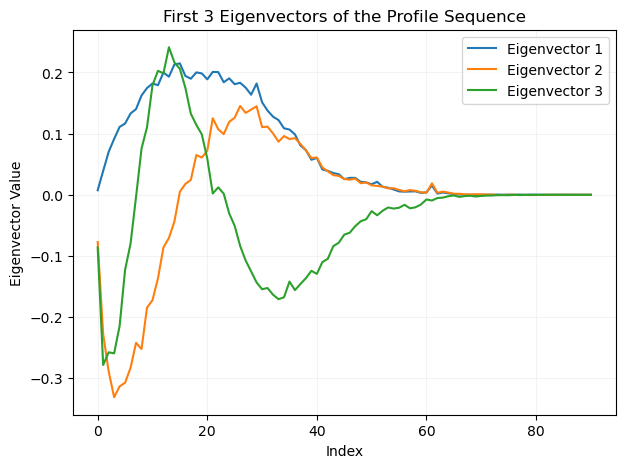

In [75]:
# Perform PCA on profile sequence
pca = PCA()
profile_sequences = actors_full_extensive_career['profileSequence'].tolist()
X = np.array(profile_sequences)
pca.fit(X)

# Get the principal components
principal_components = pca.components_

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Print the explained variance ratio for the first 5 principal components
for i in range(5):
    print(f"Explained Variance (Eigenvector {i+1}): {explained_variance_ratio[i]:.2f}")

# Plot the first 3 eigenvectors of the profile sequence
plt.figure(figsize=(7, 5))

for i in range(3):
    plt.plot(principal_components[i], label=f'Eigenvector {i+1}')

plt.xlabel('Index')
plt.ylabel('Eigenvector Value')
plt.title('First 3 Eigenvectors of the Profile Sequence')
plt.legend()
plt.grid(alpha=0.15)
plt.show()

Examining the first eigenvector, which explains the highest variance (0.27), reveals significant positive weights assigned to career years 5 to 35. This suggests that this eigenvector captures a pattern where certain actors compared to others experience increased engagement and activity during this specific time frame, contributing significantly to the overall variance.

In the second eigenvector with a variance of 0.10, negative weights are noticeable in the first 15 years, followed by positive weights extending up to year 60. The third eigenvector, explaining 0.05 variance, displays very negative weights in the initial 5 years, followed by positive weights from year 5 to 25. Afterward, there's a shift to negative weights until year 60, with a notable peak around year 35. 

Additionally, it can be noted that the three eigenvectors considered are almost null for the final 30 career years. This observation aligns with the expectation, as most actors don't have such lengthy careers and, therefore, do not star in movies during this extended period.

These interpretations provide insights into the temporal patterns captured by each eigenvector and how they contribute to the overall variance in the dataset.

#TODO rewrite this and interpret

Now that we have a general understanding of the various types of career trajectories, let's delve into a more detailed analysis of more specific factors. First, we'll examine the age of actors at their first movie appearance.

The mean age at first movie appearance is 29.76 years old.
The median age at first movie appearance is 29.00 years old.
Minimum age at first movie appearance: 1.0
Maximum age at first movie appearance: 82.0


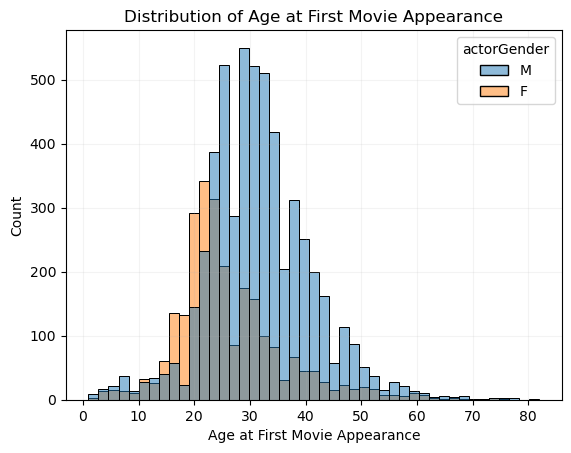

In [16]:
# Statistics on age at first movie appearance
mean_age = actors_full_extensive_career['ageAtFirstMovie'].mean()
median_age = actors_full_extensive_career['ageAtFirstMovie'].median()

print(f"The mean age at first movie appearance is {mean_age:.2f} years old.")
print(f"The median age at first movie appearance is {median_age:.2f} years old.")
print("Minimum age at first movie appearance:", actors_full_extensive_career['ageAtFirstMovie'].min())
print("Maximum age at first movie appearance:", actors_full_extensive_career['ageAtFirstMovie'].max())

# Plot histogram of age at first movie appearance
sns.histplot(data=actors_full_extensive_career, x='ageAtFirstMovie', bins=45, hue='actorGender')
plt.title("Distribution of Age at First Movie Appearance")
plt.xlabel("Age at First Movie Appearance")
plt.ylabel("Count")
plt.grid(alpha=0.15)
plt.show()

Based on the observed distributions, it appears that there is a discrepancy in the age at which individuals of different genders make their first movie appearances, with male actors seemingly starting at an older age compared to female actors. 

To formally test this observation, we can conduct a t-test with the null hypothesis that the mean age at first movie for both genders is equal, which will help confirm whether the observed difference is statistically significant or could be due to random chance.

In [17]:
men_data = actors_full_extensive_career.loc[actors_full_extensive_career['actorGender'] == 'M', 'ageAtFirstMovie']
women_data = actors_full_extensive_career.loc[actors_full_extensive_career['actorGender'] == 'F', 'ageAtFirstMovie']

# Perform the t-test
t_stat, p_value = ttest_ind(men_data.dropna(), women_data.dropna(), equal_var=False, alternative='greater')

# Print the results
print(f"t-statistic: {t_stat:.2f}")
print(f"p-value: {p_value:.2f}")


t-statistic: 24.24
p-value: 0.00


Given the obtained p-value that is below the statistical significance threshold, it is extremely unlikely to observe such a large difference in age at first movie appearance between men and women if there were no true difference in the population. Therefore, we may reject the null hypothesis. It can thus be suggested that the age at which male actors make their first movie appearance is statistically significantly greater than that of female actors.

The mean career length is 27.36 years.
The median career length is 26.00 years.


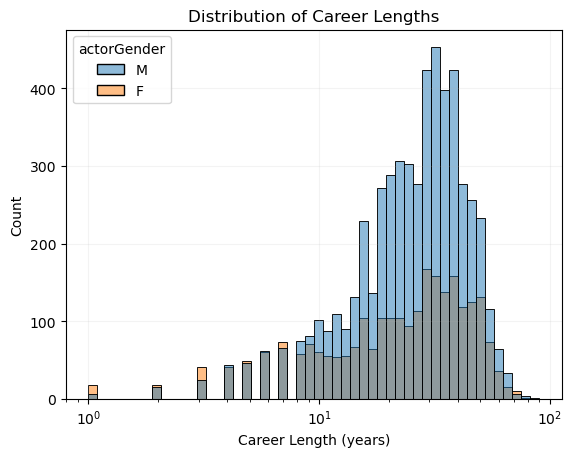

In [18]:
mean_career_length = actors_full_extensive_career['careerLength'].mean()
median_career_length = actors_full_extensive_career['careerLength'].median()

print(f"The mean career length is {mean_career_length:.2f} years.")
print(f"The median career length is {median_career_length:.2f} years.")

sns.histplot(data=actors_full_extensive_career, x='careerLength', bins=50, hue='actorGender', log_scale=True)
plt.title("Distribution of Career Lengths")
plt.xlabel("Career Length (years)")
plt.ylabel("Count")
plt.grid(alpha=0.15)
plt.show()

A t-test was conducted to assess whether there is a statistically significant difference in the career lengths between male and female actors.

In [19]:
# Extract career lengths for male and female actors
male_career_lengths = actors_full_extensive_career[actors_full_extensive_career['actorGender'] == 'M']['careerLength']
female_career_lengths = actors_full_extensive_career[actors_full_extensive_career['actorGender'] == 'F']['careerLength']

# Perform the t-test
t_stat, p_value = ttest_ind(male_career_lengths.dropna(), female_career_lengths.dropna(), equal_var=False, alternative='greater')

# Print the results
print(f"t-statistic: {t_stat:.2f}")
print(f"p-value: {p_value:.2f}")


t-statistic: 5.17
p-value: 0.00


The p-value obtained is below the significance threshold 0.05, indicating that there is sufficent evidence to reject the null hypothesis. In other words, the observed difference in the means of career lengths between male and female actors is statistically significant. 


Moreover, we can explore the number of active years for actors throughout their career span. An active year is defined as a year in which an actor participated in a movie.

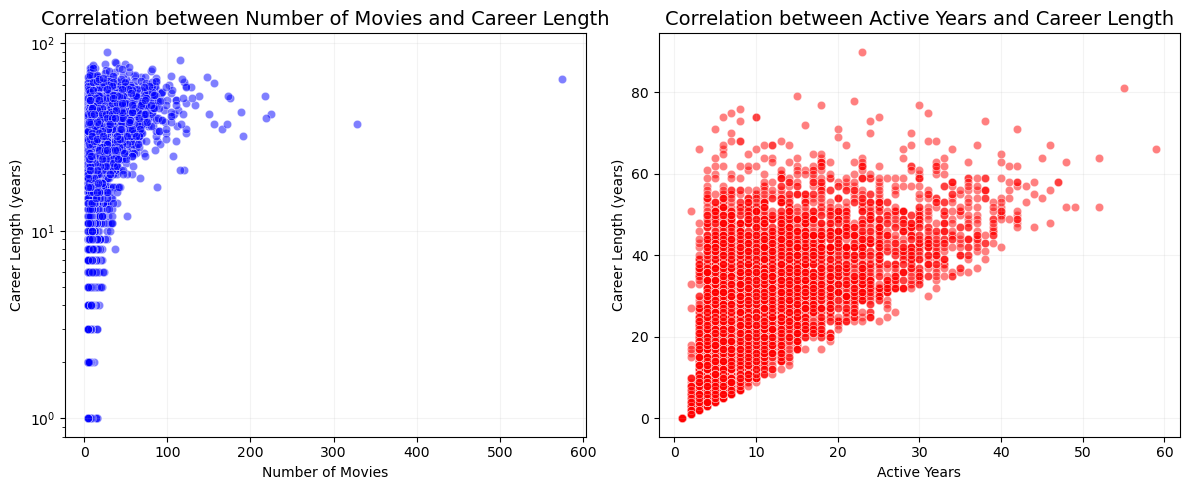

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(data=actors_full_extensive_career, x='numMovies', y='careerLength', ax=ax1, color='blue', alpha=0.5)
ax1.set_title("Correlation between Number of Movies and Career Length", fontsize=14)
ax1.set_xlabel("Number of Movies")
ax1.set_yscale('log')
ax1.set_ylabel("Career Length (years)")
ax1.grid(alpha=0.15)

# Extract unique age values from ageAtMovieRelease dictionary
actors_full_extensive_career['activeYears'] = actors_full_extensive_career['ageAtMovieRelease'].apply(
    lambda x: len(set(x.values())) if isinstance(x, dict) else np.nan)

sns.scatterplot(data=actors_full_extensive_career, x='activeYears', y='careerLength', ax=ax2, color='red', alpha=0.5)
ax2.set_title("Correlation between Active Years and Career Length", fontsize=14)
ax2.set_xlabel("Active Years")
ax2.set_ylabel("Career Length (years)")
ax2.grid(alpha=0.15)

plt.tight_layout()
plt.show()

We can observe that a significant number of actors maintain extensive careers despite being engaged in only a relatively small number of movies. There doesn't appear to be much of a correlation between career length and active years, suggesting that there is no universal trend for all actors. This is expected, as only a select few achieve notable success in their careers, reflected in a number of active years close to the career length.

In [33]:
# Calculate Pearson correlation coefficients
corr_movies_career = actors_full_extensive_career['numMovies'].corr(actors_full_extensive_career['careerLength'])
corr_active_years_career = actors_full_extensive_career['activeYears'].corr(actors_full_extensive_career['careerLength'])

print(f"Pearson Correlation (Number of Movies vs. Career Length): {corr_movies_career:.2f}")
print(f"Pearson Correlation (Active Years vs. Career Length): {corr_active_years_career:.2f}")


Pearson Correlation (Number of Movies vs. Career Length): 0.43
Pearson Correlation (Active Years vs. Career Length): 0.59


In [37]:
# Calculate the Pearson correlation coefficient between active years and career length
corr_s_l = pearsonr(actors_full_extensive_career['activeYears'], actors_full_extensive_career['careerLength'])[0]

print(f"Pearson Correlation (Active Years vs. Career Length): {corr_s_l:.2f}")

# Generate a null model (by shuffling the rows randomly, so that the relationship between 'careerLength' and 'activeYears' 
# is disrupted)
null_model = actors_full_extensive_career[['careerLength', 'activeYears']].sample(frac=1)

# Calculate the Pearson correlation coefficient for the null model
corr_null_model = pearsonr(null_model['activeYears'], null_model['careerLength'])[0]

print(f"Pearson Correlation (Null Model): {corr_null_model:.2f}")


Pearson Correlation (Active Years vs. Career Length): 0.59
Pearson Correlation (Null Model): 0.59


To validate the relationship between active years (s) and career length (L), the Pearson correlation coefficient (r) was computed. The observed correlation coefficient for actors was approximately r ≈ 0.59.

In order to assess the significance of this correlation, a null model was created by randomly sampling values of L and s from the pool of career profiles, ensuring L ≥ s. The Pearson correlation coefficient for the null model was found to be approximately r_null ≈ 0.59.

Comparing the observed correlation with the null model results, it seems that the correlation between active years and career length is not significantly different from what could be expected by random chance alone, as demonstrated by the similarity between the observed and null model correlation coefficients.

In summary, while there is a correlation between the activity (s) and career length (L) for actors, this correlation can be largely attributed to a null model. Consequently, the efficiency of actors, quantified as the ratio of active years to career length, appears to be an unpredictable quantity.
